**0. Importing libaries**

In [ ]:
# Dataframes and numpy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# ML libaries
import torch # pytorch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnnu # For packing sequences https://pytorch.org/docs/0.4.0/nn.html#torch.nn.utils.rnn.pack_padded_sequence

# Progress bars
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

# Natural language processing (nlp)
import spacy

# Plotting
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

BATCH_SIZE = 16

****1. Data prep****

 Loading the datasets 
 
 and
 
 Data pre-processing
* Remove capitalization
* (Remove stopwords) -> I skipped this and still got good results
* Tokenize sentences into words
* (Lemmazation to remove word endings) -> Not necessary with word vectors
* Embedding words into vectors

In [ ]:
foo = pd.read_csv("../input/train.tsv", sep='\t')
foo.iloc[0:100].to_csv("../toycase.tsv", sep='\t')

In [ ]:
# natural language processor, see spacy documentation. Disable some unneeded components
nlp = spacy.load("en_core_web_lg",disable = ["parser","tagger","ner"])

def sentenceToNNInput(sentence):
    doc = nlp(sentence) # Tokenize
    return [torch.tensor(token.vector) for token in doc]

In [ ]:
# Creating the dataset https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class review_dataset(Dataset):
    def __init__(self,path):
        df = pd.read_csv(path, sep='\t')
        self.len = df.shape[0]
        if 'Sentiment' in df.columns: # Only training set has a sentiment column
            self.labels = torch.from_numpy(df["Sentiment"].values)
        else:
            self.labels = torch.zeros(self.len)    
        self.inputs = df["Phrase"].progress_apply(sentenceToNNInput).values.tolist()
        self.lengths = torch.tensor([len(elm) for elm in self.inputs])
        self.phraseid = torch.from_numpy(df["PhraseId"].values)

    def __getitem__(self, index):
        # Returns a list of tuples (input,label,length) where label and lenghts are scalar (0-D torch tensor) 
        # and input is a list of 1-D Tensors representing a word each
        return self.inputs[index], self.labels[index], self.lengths[index], self.phraseid[index]

    def __len__(self):
        return (self.len)

In [ ]:
#train = review_dataset("../toycase.tsv")
train = review_dataset("../input/train.tsv")

In [ ]:
#train = pd.read_csv("../input/train.tsv", sep='\t')
#test = pd.read_csv("../input/test.tsv", sep='\t')
#toycase = pd.read_csv("../toycase.tsv", sep='\t')
#train.head()
train[7][3]

In [ ]:
# For packing the batches need to be sorted in decreasing sentence lengths
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X, y, lengths

In [ ]:
# Collate function so that dataloader works with inputs with variable sequence lengths
def my_collate(batch):
    inputs = [torch.stack(x[0]) for x in batch]
    labels = torch.tensor([x[1] for x in batch])
    lengths = torch.tensor([x[2] for x in batch])
    inputs = rnnu.pad_sequence(inputs,batch_first = True) # Pad sentences so they have the same length
    inputs, labels, lengths = sort_batch(inputs, labels, lengths) # Sort batches for packing
    return inputs, labels, lengths

In [ ]:
split_lengths = [int(len(train)*0.8), int(len(train)*0.2)]
train, dev = torch.utils.data.dataset.random_split(train, split_lengths)
train_loader = DataLoader(dataset = train, batch_size = BATCH_SIZE, collate_fn = my_collate)
dev_loader = DataLoader(dataset = dev, batch_size = BATCH_SIZE, collate_fn = my_collate)
# Enumerating over this loader like this -> for i, data in enumerate(trainloader)
# returns data in the tuple (inputs, labels, lenghts) where inputs, labels and lengths all are
# of length BATCH_SIZE 


In [ ]:
#next(iter(train_loader))

**2. Defining the model**

LSTM 

In [ ]:
class myLSTM(nn.Module):
    def __init__(self,embedding_dim, n_hidden, n_out):
        super(myLSTM, self).__init__()
        self.n_hidden,self.n_out =  n_hidden, n_out
        self.lstm = nn.LSTM(embedding_dim, n_hidden, batch_first = True) # LSTM layer
        self.out = nn.Linear(n_hidden, n_out) # Output layer, converting LSTM hidden states to predictions
        
    def forward(self, sentences, lengths):
        # Packing and padding to save some computation time
        sentences = rnnu.pack_padded_sequence(sentences, lengths, batch_first = True)  # !! MISSING sorting in decreasing order
        
        lstm_out, _ = self.lstm(sentences) # Input should have shape (#Batches, Sequence Length, Vector Size)
        lstm_out, _ = rnnu.pad_packed_sequence(lstm_out,batch_first = True)
        
        # For classification we only need the last timesteps. Code for selecting last timesteps from: https://blog.nelsonliu.me/2018/01/24/extracting-last-timestep-outputs-from-pytorch-rnns/
        idx = (lengths - 1).view(-1, 1).expand(len(lengths), lstm_out.size(2))
        idx = idx.unsqueeze(1).type(torch.LongTensor)
        if lstm_out.is_cuda:
            idx = idx.cuda(lstm_out.data.get_device())
        # Shape: (batch_size, lstm_hidden_dim)
        last_output = lstm_out.gather(1, idx).squeeze(1)
        
        # Linear layer
        return self.out(last_output)
    

**3. Fitting and evaluation function**

In [ ]:
def fit(model,train_loader, optimizer, criterion):
    model.train()
    device = next(model.parameters()).device.index
    losses = []
    for i, data in enumerate(train_loader):
        sentences = data[0].type(torch.FloatTensor).cuda(device)
        labels = data[1].type(torch.LongTensor).cuda(device)
        lengths = data[2].type(torch.LongTensor).cuda(device)
        # sorting and padding moved to collate_fn
        #sentences, labels, lengths = sort_batch(sentences, labels, lengths) # Sort batches for packing
        #sentences = rnnu.pad_sequence(sentences,batch_first = True) # Pad sentences so they have the same length
        
        pred_labels = model(sentences, lengths)
        loss = criterion(pred_labels, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [ ]:
def eval(model,test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        sentences = data[0].type(torch.FloatTensor).cuda(device)
        labels = data[1].type(torch.LongTensor).cuda(device)
        lengths = data[2].type(torch.LongTensor).cuda(device)
        
        real_labels += list(labels.cpu().detach().numpy())
        
        pred_label = model(sentences, lengths)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

**4. Training the model**

Parameters and training run

In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 20
embedding_dim = 300 # Number of features in the spacy word vectors
n_hidden = 4 # TODO: Try different numbers !
n_out = 5 # We have 5 classes (0-4)
model = myLSTM(embedding_dim, n_hidden, n_out).cuda()
optimizer = torch.optim.Adam(model.parameters()) # TODO: Try different learning rate, optimizers !

In [ ]:
train_loss1 = []
test_accuracy1 = []
for epoch in tqdm_notebook(range(num_epochs)):
    train_loss1.append(fit(model, train_loader, optimizer, criterion))
    test_accuracy1.append(eval(model, dev_loader))


In [ ]:
# Plotting the loss 
plt.plot(train_loss1, 'r', linestyle='-', alpha=0.5)
plt.title('training loss')
plt.xlabel('epoch')
plt.ylabel("loss")
#plt.ylim(0,1.2)
#plt.xlim(0,250)
plt.show()
plt.savefig('../loss{}.png'.format(n_hidden))

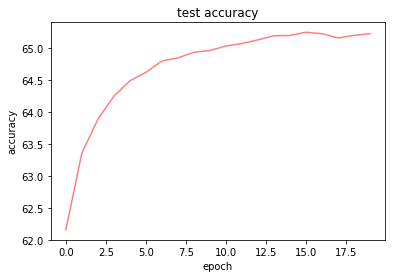

<Figure size 432x288 with 0 Axes>

In [37]:
# Plotting test accuracy
plt.plot(test_accuracy1, 'r', linestyle='-', alpha=0.5)
plt.title('test accuracy')
plt.xlabel('epoch')
plt.ylabel("accuracy")
#plt.ylim(0,1.2)
#plt.xlim(0,250)
plt.show()
plt.savefig('../acc{}.png'.format(n_hidden))

**5. Predicting scores and creating submission file**

In [ ]:
test = review_dataset("../input/test.tsv")

In [ ]:
model.eval()
device = next(model.parameters()).device.index
pred_labels = []

for i, data in enumerate(tqdm_notebook(test)):
    inputs = torch.stack(data[0]).type(torch.FloatTensor).cuda(device).unsqueeze_(0)
    length = data[2].type(torch.FloatTensor).cuda(device).unsqueeze_(0)
    
    pred_label = model(inputs, length).cpu().detach().numpy().argmax()
    pred_labels.append(pred_label)

In [ ]:
phraseid = test[:][3].tolist()
results = pd.DataFrame(
    {'PhraseId': phraseid,
     'Sentiment': pred_labels})

results.to_csv("submission{}.csv".format(n_hidden),index=False)

> **X. Ressources:** 

pack padded sequence  
![](http://)https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130
https://discuss.pytorch.org/t/example-of-many-to-one-lstm/1728/2

https://medium.com/@florijan.stamenkovic_99541/rnn-language-modelling-with-pytorch-packed-batching-and-tied-weights-9d8952db35a9

Dataloader

https://www.youtube.com/watch?v=zN49HdDxHi8

Collate :  
https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/
